<a href="https://colab.research.google.com/github/AlessLG/practicas_curvas-de-rotacion/blob/main/ajustes_curvas_rotacion_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# G = 4.3e-3 # pc • (km/s)² / M_⊙
G = 4.3e-6 # kpc • (km/s)² / M_⊙

descargar_figuras = False

def v_Hernquist(r, M, a):
    return np.sqrt(G*M*r/(a+r)**2)

def v_plummer(r, M, a):
    return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))

def v_nfw(r, A, r_s):
    return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))

def v_sol_reparam(r, rho_c, a):
    B = rho_c * (a**16)
    return v_sol(r, B, a)

def v_sol(r, B, a, G=4.3e-6):
    r_safe = np.where(r == 0, 1e-9, r)
    poly_part = (
        -0.177069 * a**13 * r_safe
        + 0.225911 * a**11 * r_safe**3
        + 0.039069 * a**9 * r_safe**5
        + 0.0039039 * a**7 * r_safe**7
        + 0.000229089 * a**5 * r_safe**9
        + 7.36645e-6 * a**3 * r_safe**11
        + 1.00552e-7 * a * r_safe**13
    )
    arctan_poly_part = (
        0.586978 * a**14
        + 0.373905 * a**12 * r_safe**2
        + 0.102076 * a**10 * r_safe**4
        + 0.0154815 * a**8 * r_safe**6
        + 0.00140882 * a**6 * r_safe**8
        + 7.69216e-5 * a**4 * r_safe**10
        + 2.33329e-6 * a**2 * r_safe**12
        + 3.03327e-8 * r_safe**14
    )
    arctan_term = arctan_poly_part * np.arctan(0.301662 * r_safe / a)
    numerator_content = B * G * (poly_part + arctan_term)
    denominator = a**13 * r_safe * (a**2 + 0.091 * r_safe**2)**7
    term_inside_sqrt = np.maximum(0, (4 * np.pi * numerator_content) / denominator)
    velocity = np.sqrt(term_inside_sqrt)
    if np.isscalar(r):
        if r == 0: return 0.0
    else:
        velocity[r == 0] = 0.0
    return velocity

In [15]:
def fit_and_plot_rotation_curve(file_path, show_plot=True, save_plot_path=None):
    """
    Carga datos de una curva de rotación, ajusta 4 modelos de halo,
    imprime los resultados y genera un gráfico.

    Parámetros:
    ----------
    file_path : str
        Ruta al archivo de datos .dat (ej. '/content/F563-1_rotmod.dat').
    show_plot : bool, opcional
        Si es True (por defecto), muestra el gráfico generado.
    save_plot_path : str, opcional
        Si se proporciona una ruta (ej. 'F563-1.png'), guarda el gráfico en ese archivo.

    Retorna:
    -------
    dict
        Un diccionario con los resultados detallados de los ajustes para cada modelo.
    """

    # --- 1. Carga de Datos ---
    data = np.genfromtxt(file_path, delimiter='\t')
    r_data = data[:, 0]
    v_data = data[:, 1]
    err_data = data[:, 2]

    # --- 2. Preparación de Modelos y Ajuste ---
    perfiles_std = [v_Hernquist, v_plummer, v_nfw]
    nombres_std = ["Hernquist", "Plummer", "NFW"]
    resultados = {}

    def residuals(params, perfil, r, v_obs, v_err):
        p1, p2 = params
        return (perfil(r, p1, p2) - v_obs) / v_err

    # Ajuste de los 3 modelos estándar
    x0_std = [1e11, 10.0]
    for i, perfil in enumerate(perfiles_std):
        result = least_squares(residuals, x0_std, args=(perfil, r_data, v_data, err_data), bounds=([0, 0], [np.inf, np.inf]))
        params_fit = result.x
        J = result.jac
        N = len(v_data)
        k = len(params_fit)

        # Calcular errores solo si el ajuste es bueno
        try:
            cov_matrix = np.linalg.inv(J.T @ J)
            params_err = np.sqrt(np.diag(cov_matrix))
        except np.linalg.LinAlgError:
            params_err = np.array([np.inf, np.inf]) # Errores infinitos si la matriz no es invertible

        chi2 = np.sum(result.fun**2)
        dof = N - k
        chi2_red = chi2 / dof if dof > 0 else np.inf

        resultados[nombres_std[i]] = {"params": params_fit, "errors": params_err, "chi2_red": chi2_red}

    # Ajuste específico para el modelo Solitón
    x0_sol = [1e7, 10.0]
    result_sol = least_squares(residuals, x0_sol, args=(v_sol_reparam, r_data, v_data, err_data), bounds=([0, 0], [np.inf, np.inf]))
    params_fit_sol = result_sol.x
    J_sol = result_sol.jac

    try:
        cov_matrix_sol = np.linalg.inv(J_sol.T @ J_sol)
        params_err_sol = np.sqrt(np.diag(cov_matrix_sol))
    except np.linalg.LinAlgError:
        params_err_sol = np.array([np.inf, np.inf])

    chi2_sol = np.sum(result_sol.fun**2)
    dof_sol = len(v_data) - len(params_fit_sol)
    chi2_red_sol = chi2_sol / dof_sol if dof_sol > 0 else np.inf

    resultados["Solitón"] = {"params": params_fit_sol, "errors": params_err_sol, "chi2_red": chi2_red_sol}

    # --- 3. Impresión de Resultados ---
    galaxy_name = os.path.basename(file_path).split('_')[0]
    print(f"\n--- Resultados de Ajustes para la Galaxia: {galaxy_name} ---")
    for nombre, res in sorted(resultados.items(), key=lambda item: item[1]['chi2_red']):
        p1, p2 = res['params']
        e1, e2 = res['errors']
        chi2_red = res['chi2_red']

        print(f"{nombre}: (χ²_red = {chi2_red:.3f})")
        if nombre == "Solitón":
            print(f"  ρ_c   = ({p1:.2e} ± {e1:.1e}) M⊙/kpc³")
            print(f"  a     = ({p2:.2f} ± {e2:.2f}) kpc")
        elif nombre == "NFW":
            print(f"  A     = ({p1:.2e} ± {e1:.1e}) M⊙")
            print(f"  r_s   = ({p2:.2f} ± {e2:.2f}) kpc")
        else: # Hernquist y Plummer
            print(f"  Masa  = ({p1:.2e} ± {e1:.1e}) M⊙")
            print(f"  a     = ({p2:.2f} ± {e2:.2f}) kpc")
        print("-" * 45)

    # --- 4. Generación del Gráfico ---
    plt.figure(figsize=(6, 4))
    d = np.linspace(0.1, r_data[-1], 200)

    # Curvas de los modelos
    v_h = v_Hernquist(d, *resultados['Hernquist']['params'])
    v_p = v_plummer(d, *resultados['Plummer']['params'])
    v_n = v_nfw(d, *resultados['NFW']['params'])
    v_s = v_sol_reparam(d, *resultados['Solitón']['params'])

    # Datos observacionales
    plt.errorbar(r_data, v_data, yerr=err_data, fmt='o', color='black', label='Datos', capsize=4, markersize=5)

    # Ploteo de modelos
    plt.plot(d, v_p, 'g-', label=f'Plummer (χ²_red={resultados["Plummer"]["chi2_red"]:.2f})')
    plt.plot(d, v_s, 'k:', label=f'Solitón (χ²_red={resultados["Solitón"]["chi2_red"]:.2f})')
    plt.plot(d, v_h, 'b--', label=f'Hernquist (χ²_red={resultados["Hernquist"]["chi2_red"]:.2f})')
    plt.plot(d, v_n, 'r-.', label=f'NFW (χ²_red={resultados["NFW"]["chi2_red"]:.2f})')

    plt.xlabel('Radio (kpc)')
    plt.ylabel('Velocidad de Rotación (km/s)')
    plt.title(f'Ajuste de Curva de Rotación para {galaxy_name}')
    plt.tick_params(direction='in', top=True, right=True)
    # plt.xlim(0, r_data.max() * 1.05)
    # plt.ylim(0, v_data.max() * 1.15)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    if save_plot_path:
        plt.savefig(save_plot_path, dpi=300, bbox_inches='tight')
        print(f"\nGráfico guardado en: {save_plot_path}")

    if show_plot:
        plt.show()

    plt.close() # Cierra la figura para liberar memoria

    # ¡LLAMADA A LA NUEVA FUNCIÓN!
    # Le pasamos los datos y el diccionario 'resultados' que acabamos de calcular.
    create_butterfly_plots(r_data, v_data, err_data, resultados, galaxy_name)

    return resultados


--- Resultados de Ajustes para la Galaxia: F563-1 ---
Plummer: (χ²_red = 0.918)
  Masa  = (5.47e+10 ± 5.3e+09) M⊙
  a     = (6.99 ± 0.52) kpc
---------------------------------------------
Hernquist: (χ²_red = 1.048)
  Masa  = (3.76e+11 ± 1.4e+11) M⊙
  a     = (30.10 ± 7.70) kpc
---------------------------------------------
NFW: (χ²_red = 1.068)
  A     = (2.22e+10 ± 9.4e+09) M⊙
  r_s   = (18.21 ± 5.16) kpc
---------------------------------------------
Solitón: (χ²_red = 1.556)
  ρ_c   = (3.25e+07 ± 4.8e+06) M⊙/kpc³
  a     = (4.80 ± 0.31) kpc
---------------------------------------------


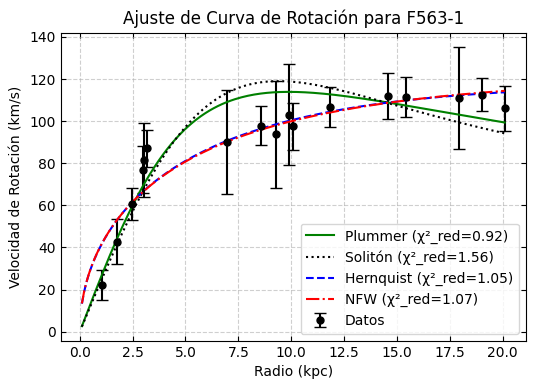

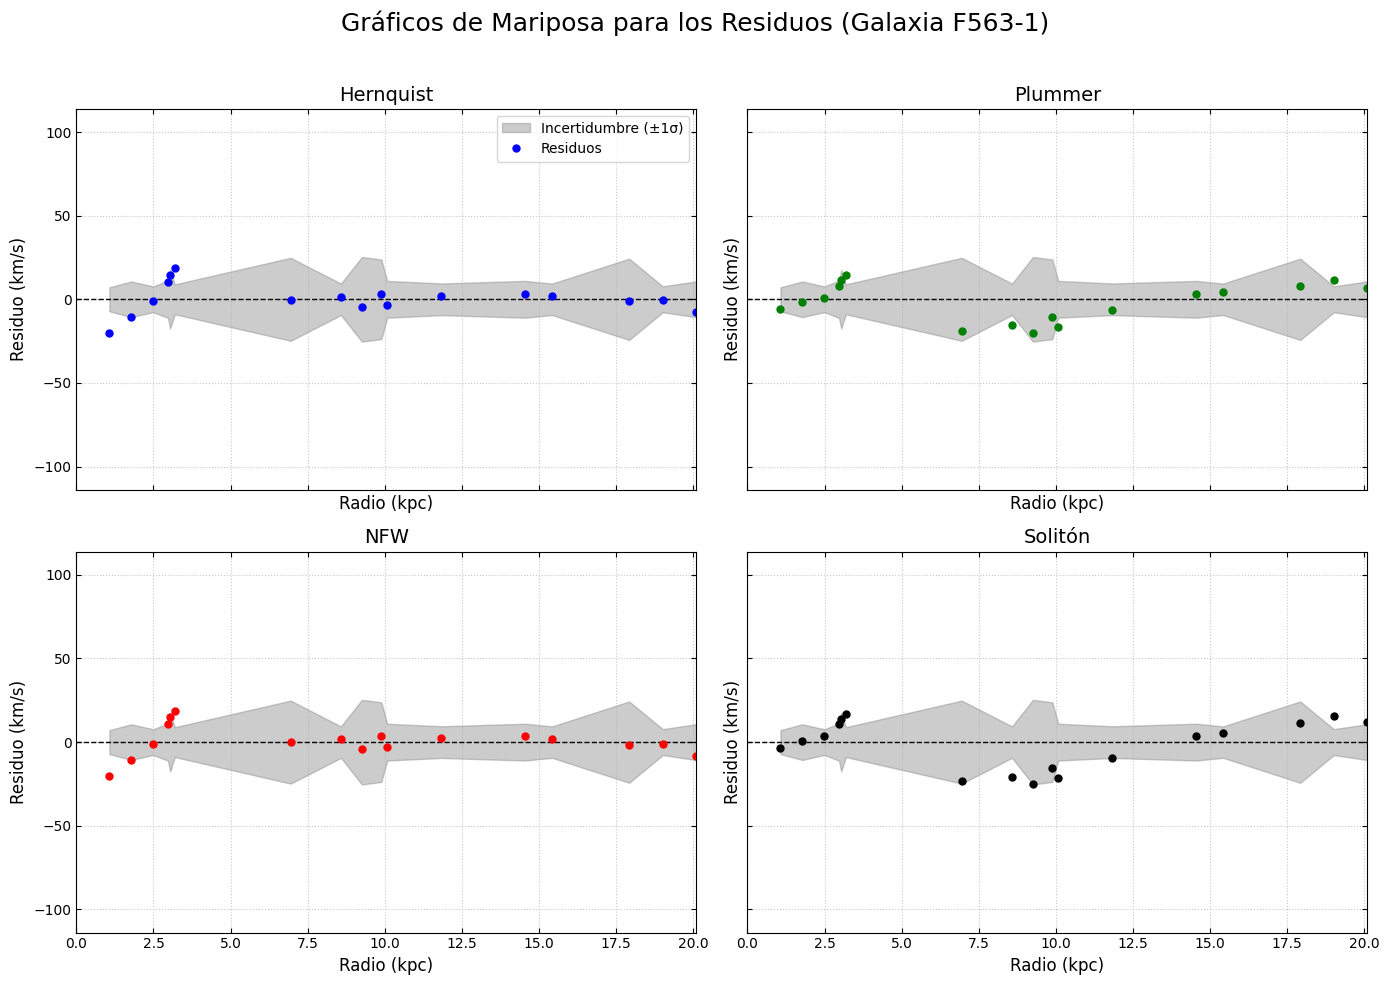


--- Resultados de Ajustes para la Galaxia: F563-V2 ---
Plummer: (χ²_red = 0.057)
  Masa  = (3.72e+10 ± 6.5e+09) M⊙
  a     = (4.37 ± 0.50) kpc
---------------------------------------------
Solitón: (χ²_red = 0.143)
  ρ_c   = (9.53e+07 ± 1.8e+07) M⊙/kpc³
  a     = (2.87 ± 0.27) kpc
---------------------------------------------
Hernquist: (χ²_red = 1.352)
  Masa  = (1.24e+12 ± 1.9e+12) M⊙
  a     = (45.87 ± 38.97) kpc
---------------------------------------------
NFW: (χ²_red = 1.359)
  A     = (8.58e+10 ± 1.4e+11) M⊙
  r_s   = (30.28 ± 27.27) kpc
---------------------------------------------


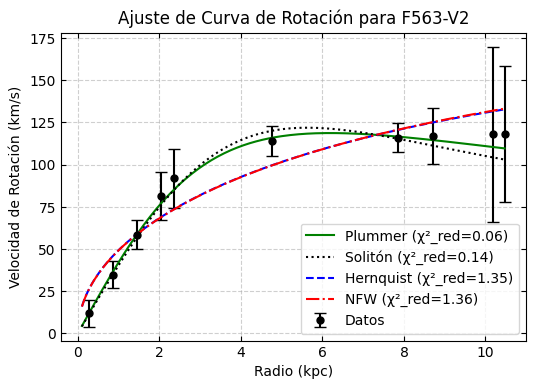

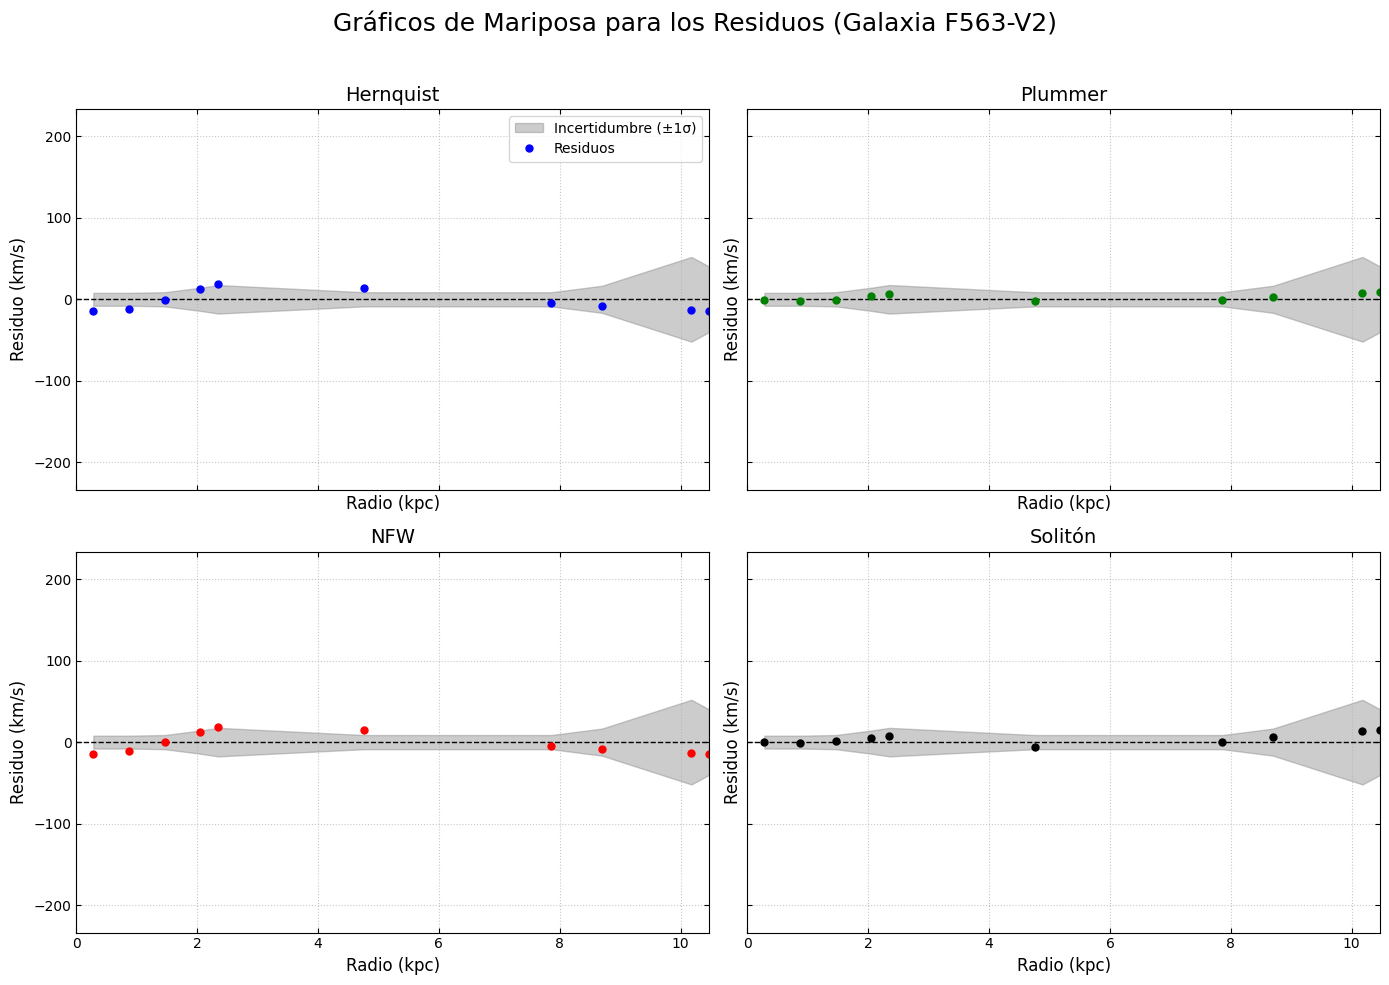


--- Resultados de Ajustes para la Galaxia: F568-1 ---
Plummer: (χ²_red = 0.129)
  Masa  = (6.33e+10 ± 8.9e+09) M⊙
  a     = (6.19 ± 0.59) kpc
---------------------------------------------
Solitón: (χ²_red = 0.292)
  ρ_c   = (5.72e+07 ± 8.6e+06) M⊙/kpc³
  a     = (4.00 ± 0.31) kpc
---------------------------------------------
Hernquist: (χ²_red = 0.793)
  Masa  = (2.47e+12 ± 3.5e+12) M⊙
  a     = (65.93 ± 52.50) kpc
---------------------------------------------
NFW: (χ²_red = 0.797)
  A     = (1.70e+11 ± 2.6e+11) M⊙
  r_s   = (43.33 ± 36.28) kpc
---------------------------------------------


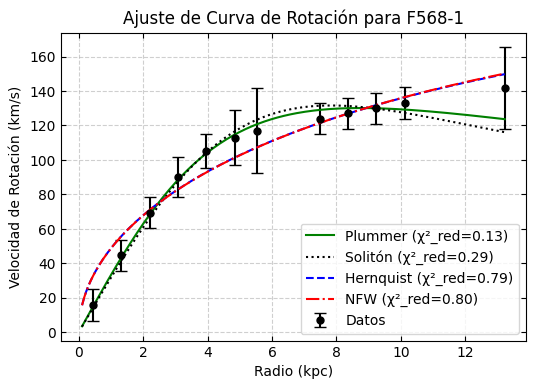

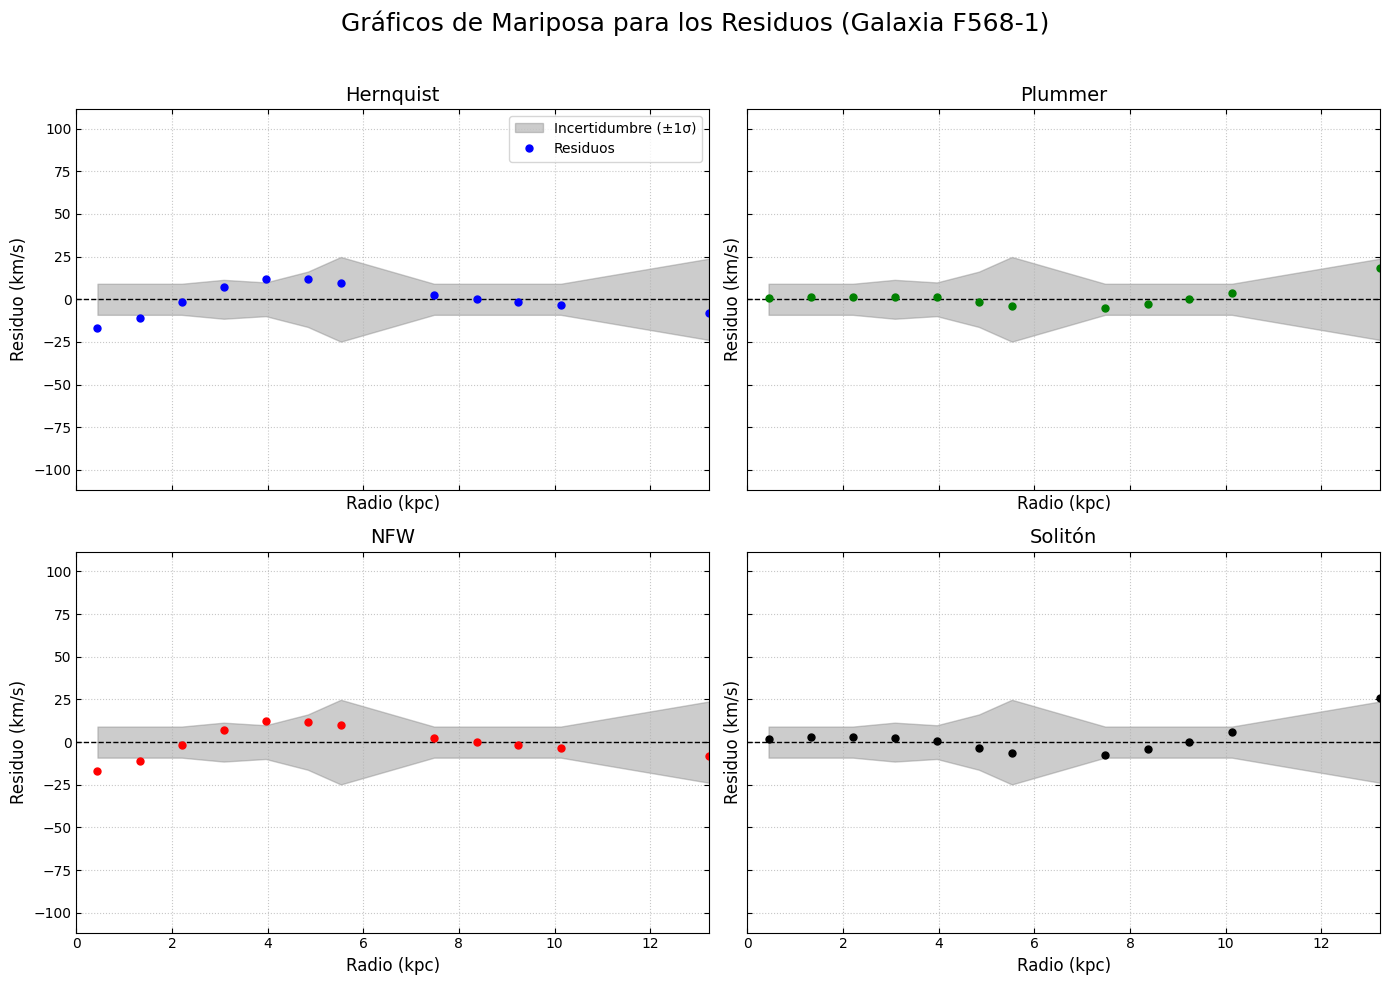


--- Resultados de Ajustes para la Galaxia: F568-3 ---
Plummer: (χ²_red = 0.648)
  Masa  = (6.30e+10 ± 8.0e+09) M⊙
  a     = (8.85 ± 0.53) kpc
---------------------------------------------
Solitón: (χ²_red = 0.841)
  ρ_c   = (2.05e+07 ± 1.5e+06) M⊙/kpc³
  a     = (5.57 ± 0.29) kpc
---------------------------------------------
Hernquist: (χ²_red = 3.470)
  Masa  = (1.14e+17 ± 2.3e+19) M⊙
  a     = (23215.54 ± 2378975.85) kpc
---------------------------------------------
NFW: (χ²_red = 3.484)
  A     = (3.34e+13 ± 3.2e+14) M⊙
  r_s   = (991.00 ± 4812.15) kpc
---------------------------------------------


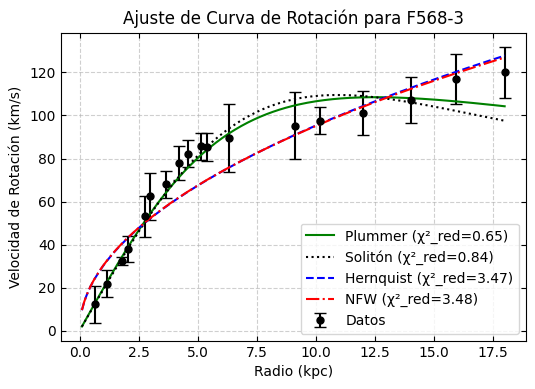

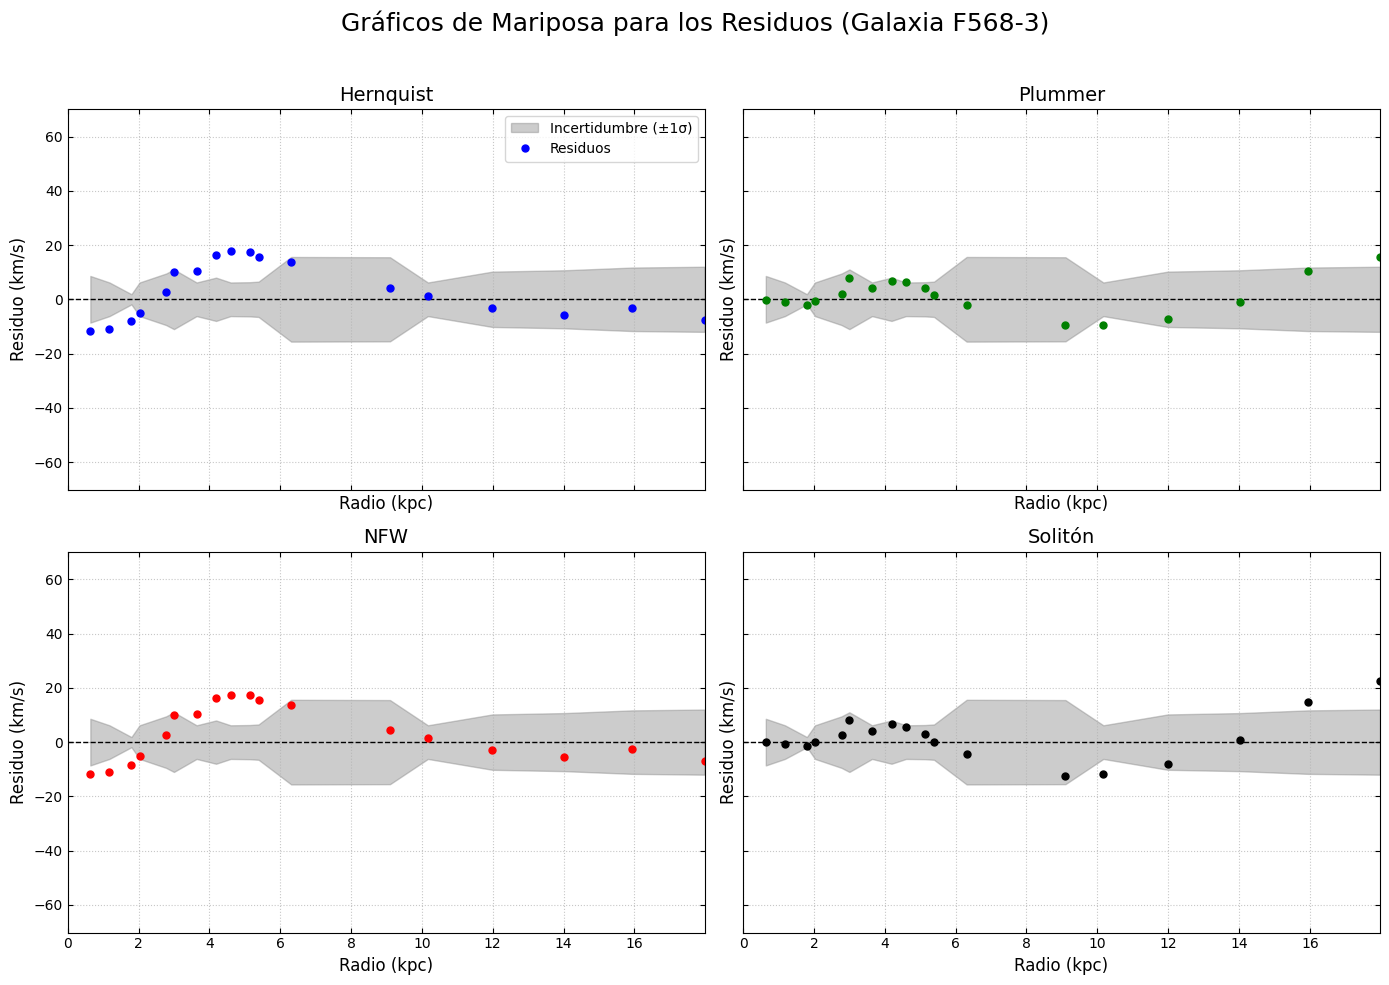

In [16]:
# Lista de archivos de galaxias que quieres analizar
galaxy_files = [
    '/content/F563-1_rotmod.dat',
    '/content/F563-V2_rotmod.dat',
    '/content/F568-1_rotmod.dat',
    '/content/F568-3_rotmod.dat'
]

# Un diccionario para guardar todos los resultados si los necesitas después
resultados = {}

# Itera sobre cada archivo, realiza el análisis completo y muestra los resultados
for file in galaxy_files:
    galaxy_name = os.path.basename(file).split('_')[0]

    # Llama a la función. Ella se encarga de todo.
    # También le decimos que guarde el gráfico en un archivo PNG con el nombre de la galaxia.
    results = fit_and_plot_rotation_curve(
        file_path=file,
        show_plot=True,
        save_plot_path=False
        # save_plot_path=f"{galaxy_name}_fit.pdf"
    )

    if results:
        resultados[galaxy_name] = results

In [14]:
def create_butterfly_plots(r_data, v_data, err_data, resultados_fit, galaxy_name):
    """
    Crea una figura 2x2 con los gráficos de mariposa para los 4 modelos ajustados.
    """
    # Función interna para dibujar un solo gráfico
    def plot_butterfly(ax, r_data, v_data, err_data, model_func, params, color, model_name):
        v_model = model_func(r_data, *params)
        residuals = v_data - v_model
        ax.fill_between(r_data, -err_data, err_data, color='gray', alpha=0.4, label='Incertidumbre (±1σ)')
        ax.axhline(0, linestyle='--', color='black', linewidth=1)
        ax.plot(r_data, residuals, 'o', color=color, markersize=5, label='Residuos')
        ax.set_title(model_name, fontsize=14)
        ax.set_xlabel('Radio (kpc)', fontsize=12)
        ax.set_ylabel('Residuo (km/s)', fontsize=12)
        ax.tick_params(direction='in', top=True, right=True)
        ax.grid(True, linestyle=':', alpha=0.7)
        max_err = np.max(err_data) * 1.5 # Un poco más de margen
        ax.set_ylim(-3 * max_err, 3 * max_err)
        ax.set_xlim(0, r_data.max())

    # --- Creación de la figura 2x2 ---
    model_functions = [v_Hernquist, v_plummer, v_nfw, v_sol_reparam]
    model_names = ["Hernquist", "Plummer", "NFW", "Solitón"]
    colors = ['b', 'g', 'r', 'k']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        model_name = model_names[i]
        # Usamos el diccionario de resultados que pasamos como argumento
        fit_params = resultados_fit[model_name]['params']
        plot_butterfly(ax, r_data, v_data, err_data, model_functions[i], fit_params, colors[i], model_name)
        # Añadimos la leyenda solo al primer plot para no repetirla
        if i == 0:
            ax.legend()


    fig.suptitle(f'Gráficos de Mariposa para los Residuos (Galaxia {galaxy_name})', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    plt.close()